<a href="https://colab.research.google.com/github/manojxk/100-DAYS-100-PROJECTS-CHALLENGE/blob/main/Stock_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing relevant packages

In [3]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
import os
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import pickle
import pandas_datareader as web
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adadelta, Adam, Adamax, Adagrad, SGD, RMSprop



%matplotlib inline
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (20, 10)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Get the stock data

Tickers I am going to use:
* AAPL [Apple]  - Yes
* For other stocks, whole process is similar


In [2]:
ticker = 'AAPL'
comp = 'Apple'
end_date = str(date.today())
df = web.DataReader(ticker, data_source='yahoo', start='2010-01-01', end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.535086
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.546384
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.442255
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.430345
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.473095
...,...,...,...,...,...,...
2022-07-29,163.630005,159.500000,161.240005,162.509995,101689200.0,162.509995
2022-08-01,163.589996,160.889999,161.009995,161.509995,67829400.0,161.509995
2022-08-02,162.410004,159.630005,160.100006,160.009995,59907000.0,160.009995


# About the Data

**High** : The highest record of stock price on that day. 

**Low** : The lowest record of stock price on that day.

**Open** : Actual stock value when the market opened for the day.

**Close** : Actual stock value when the market closed for the day. 

**Volume** : Number of shares that changed hands during a given day. Number of shares of a security traded between its daily open and close.

**Adj Close** :  The adjusted closing price factors in anything that might affect the stock price after the market closes. The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. 

# Data Summary

In [3]:
# No. of records and Features
print("NO. OF RECORDS AND FEATURES :\n")
print("No. of Records : {}".format(df.shape[0]))
print("No. of Features : {}".format(df.shape[1]))
print("----------------------------------------------------------------\n")
# Datatypes of features
print("DATATYPES OF FEATURES :\n")
print(df.info())
print("----------------------------------------------------------------\n")
# Descriptive Statistics
print("DESCRIPTIVE STATISTICS :\n")
df.describe()

NO. OF RECORDS AND FEATURES :

No. of Records : 3169
No. of Features : 6
----------------------------------------------------------------

DATATYPES OF FEATURES :

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3169 entries, 2010-01-04 to 2022-08-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3169 non-null   float64
 1   Low        3169 non-null   float64
 2   Open       3169 non-null   float64
 3   Close      3169 non-null   float64
 4   Volume     3169 non-null   float64
 5   Adj Close  3169 non-null   float64
dtypes: float64(6)
memory usage: 173.3 KB
None
----------------------------------------------------------------

DESCRIPTIVE STATISTICS :



,High,Low,Open,Close,Volume,Adj Close
count,3169.000000,3169.000000,3169.000000,3169.000000,3.169000e+03,3169.000000
mean,48.628205,47.585503,48.098193,48.129416,2.618707e+08,46.363925
std,45.110969,44.001184,44.535677,44.584488,2.239036e+08,45.108983
min,7.000000,6.794643,6.870357,6.858929,3.877928e+06,5.864506
25%,18.951786,18.616785,18.756786,18.777143,1.051040e+08,16.489206
50%,29.355000,28.877501,29.117500,29.075001,1.747996e+08,26.838413
75%,53.492500,52.557499,52.937500,53.060001,3.552752e+08,51.469643
max,182.940002,179.119995,182.630005,182.009995,1.880998e+09,181.511703


## Visualizing the Data

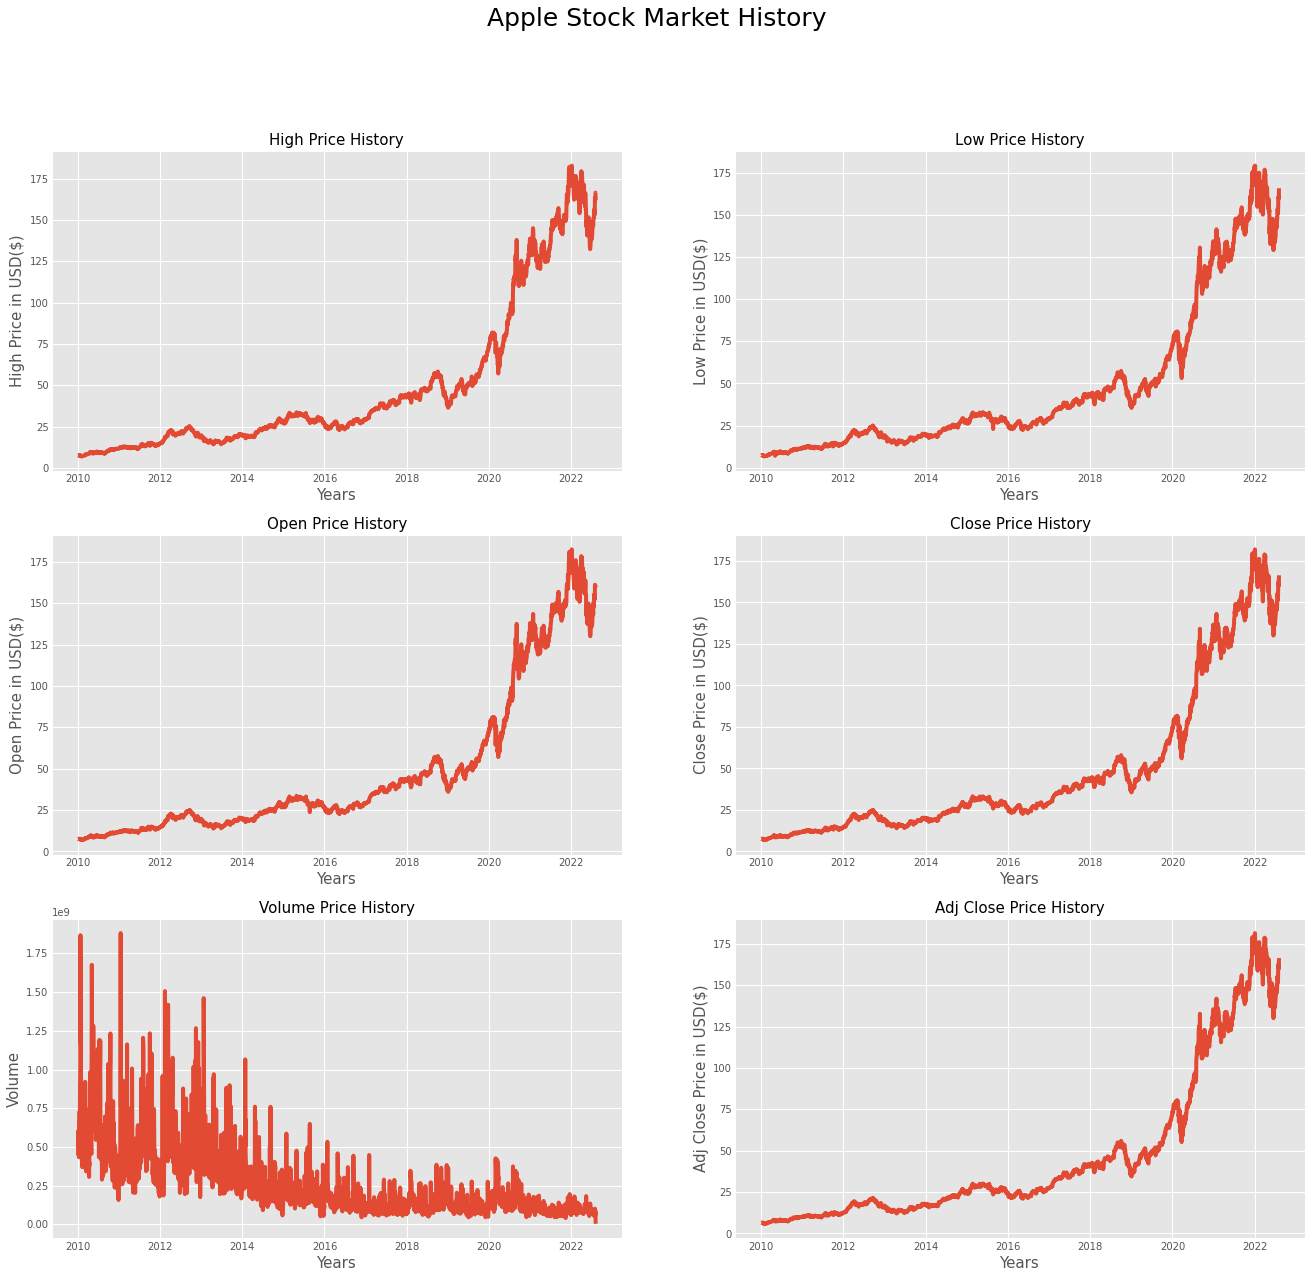

In [4]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))
plt.suptitle(comp + " Stock Market History", fontsize=25)

ax[0,0].set_title("High Price History", fontsize=15)
ax[0,0].plot(df.index, df['High'])
ax[0,0].set_xlabel('Years', fontsize=15)
ax[0,0].set_ylabel('High Price in USD($)', fontsize=15)

ax[0,1].set_title("Low Price History", fontsize=15)
ax[0,1].plot(df.index, df['Low'])
ax[0,1].set_xlabel('Years', fontsize=15)
ax[0,1].set_ylabel('Low Price in USD($)', fontsize=15)

ax[1,0].set_title("Open Price History", fontsize=15)
ax[1,0].plot(df.index, df['Open'])
ax[1,0].set_xlabel('Years', fontsize=15)
ax[1,0].set_ylabel('Open Price in USD($)', fontsize=15)

ax[1,1].set_title("Close Price History", fontsize=15)
ax[1,1].plot(df.index, df['Close'])
ax[1,1].set_xlabel('Years', fontsize=15)
ax[1,1].set_ylabel('Close Price in USD($)', fontsize=15)

ax[2,0].set_title("Volume Price History", fontsize=15)
ax[2,0].plot(df.index, df['Volume'])
ax[2,0].set_xlabel('Years', fontsize=15)
ax[2,0].set_ylabel('Volume', fontsize=15)

ax[2,1].set_title("Adj Close Price History", fontsize=15)
ax[2,1].plot(df.index, df['Adj Close'])
ax[2,1].set_xlabel('Years', fontsize=15)
ax[2,1].set_ylabel('Adj Close Price in USD($)', fontsize=15)

plt.show()

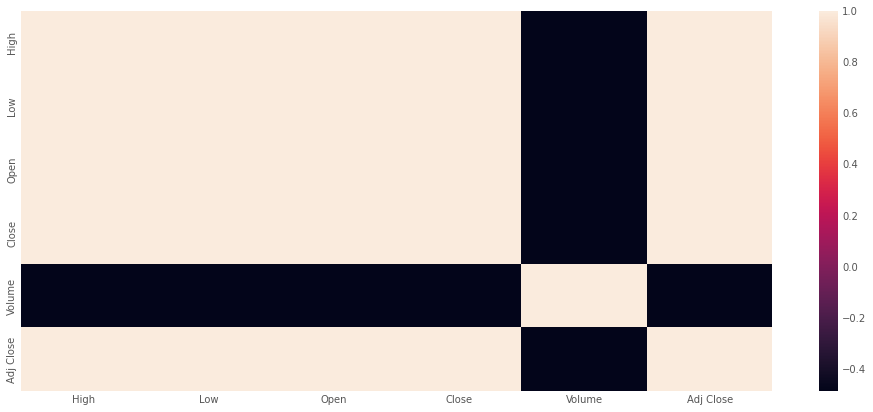

In [5]:
plt.figure(figsize=(15,7))
corr_mat = df.corr()
sns.heatmap(corr_mat)
plt.show()

### All features except `Volume` are highly correlated with each other. But we are only interested in `Close` feature for forecasting. Hence, we won't discard any feature.

##PivotTable

In [6]:
test1 = df.copy()
test1['months'] = pd.DatetimeIndex(df.index).month
test1['year'] = pd.DatetimeIndex(df.index).year
applePivot = pd.pivot_table(test1, values = "Close", columns = "year", index = "months")

In [7]:
applePivot.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
months,,,,,,,,,,,,,
1,7.418402,12.085000,15.306357,17.779371,19.194490,27.660375,24.607237,29.892500,43.501309,38.541548,77.979048,133.036842,169.861500
2,7.099850,12.542237,17.770393,16.314605,18.806429,31.358026,23.936625,33.428552,41.909737,42.931973,77.817631,131.531579,169.830001
3,7.978960,12.410388,20.625276,15.780036,19.043367,31.492727,26.066818,35.154457,43.624048,45.823453,65.611023,121.871304,165.310435
4,8.969592,12.157697,21.642964,14.991607,19.324082,31.822857,26.684762,35.721710,42.458572,50.129048,68.096547,131.812858,166.820999
5,8.980768,12.206599,20.166899,15.944740,21.542704,32.190375,23.743690,38.056932,46.384205,47.818409,77.496376,126.784000,148.430477


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f636f6d6d90>,
      dtype=object)

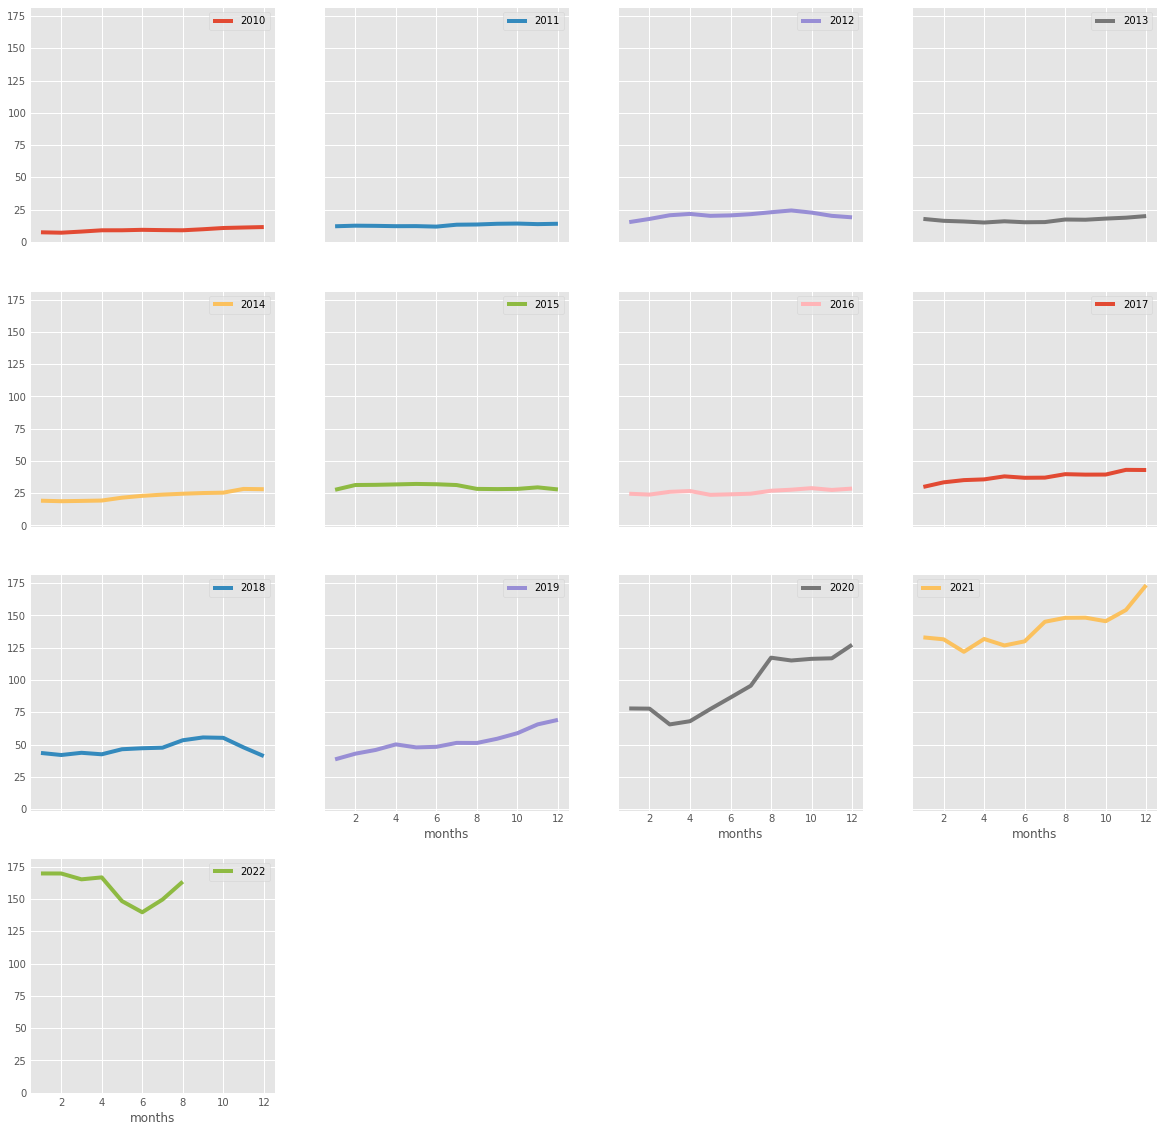

In [8]:
applePivot.plot(subplots = True, figsize=(18, 20), layout=(4,4), sharey=True)

# 3. Data Preparation

## 3.1 Let's look for any missing data here

MISSING DATA FEATUREWISE :

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64 



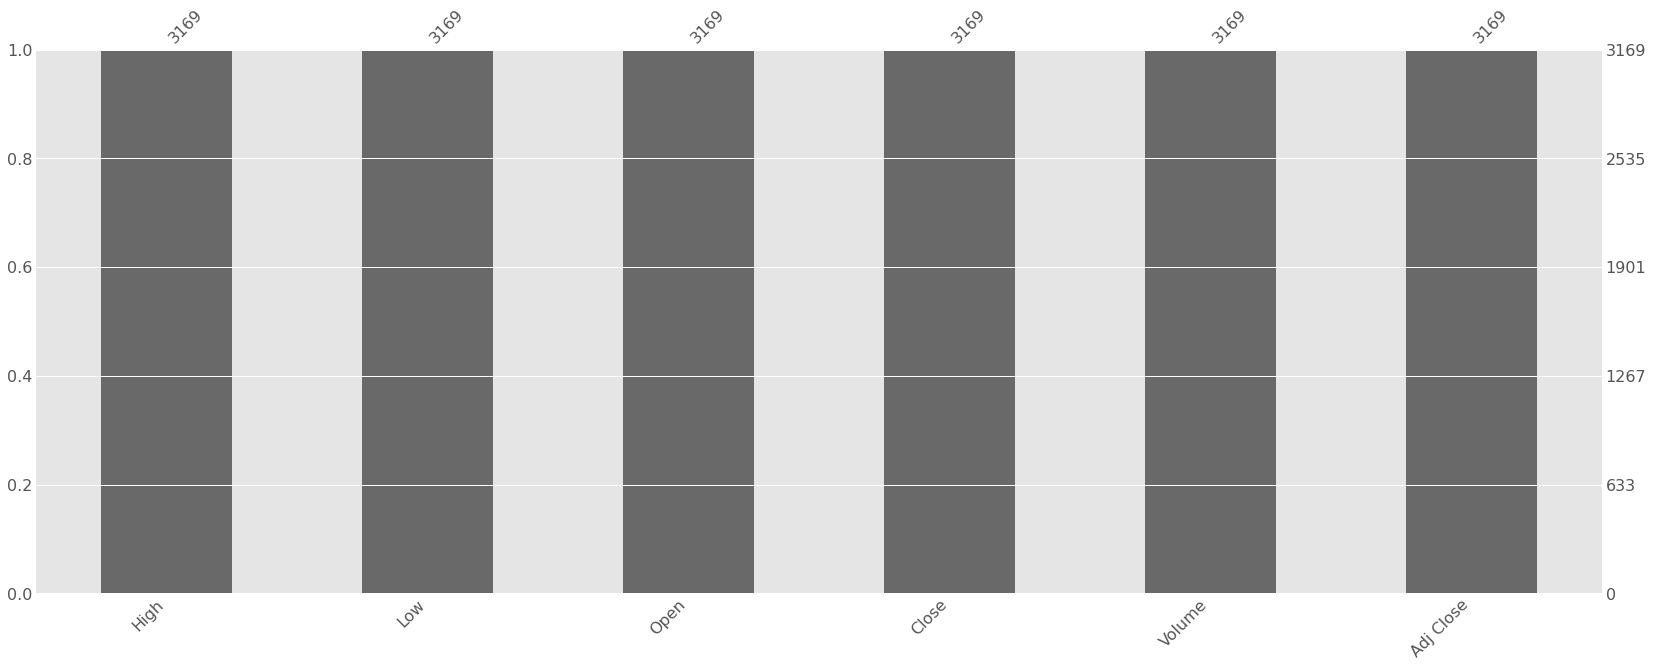

In [9]:
print("MISSING DATA FEATUREWISE :\n")
print(df.isnull().sum(),"\n")
missingno.bar(df)
plt.show()

### We can confirm that there are no missing records present in data.

#### Now, we are only interested in `Close` feature. Hence, we extract it.

In [10]:
data = df['Close'].values
print(f'There are {data.shape[0]} records in Close feature')

There are 3169 records in Close feature



Now, we will perform the following steps so that our time series data is ready to use:

1. Convert problem to a <font color='yellow'>**supervised learning problem**</font>.

2. <font color='yellow'>**Scale the data**</font>, specifically between -1 and 1 to meet the default hyperbolic tangent activation function of LSTM models.


## Preparing data matrix 

In [11]:
def prepare_data_matrix(data):
    X, y = [], []
    for i in range(0, len(data)-90):
        X.append(data[i:i+90])
        y.append(data[i+90])

    # convert X and y to numpy array
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = prepare_data_matrix(data)

# shape of X and y
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (3079, 90)
y shape :  (3079,)


## Splitting data into train and test set

In [12]:
# Splitting data into train and test - 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))

X_train shape : (2463, 90)
X_test shape : (616, 90)


## Scaling Data


In [13]:
# Scaling train data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# Scaling test data
X_test = scaler.transform(X_test)

In [14]:
# Reshape train and test data to above format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

X_train Shape :  (2463, 90, 1)
X_test Shape :  (616, 90, 1)


**We are now ready with the data and in a position to build and train our model.**

# Linear Regression

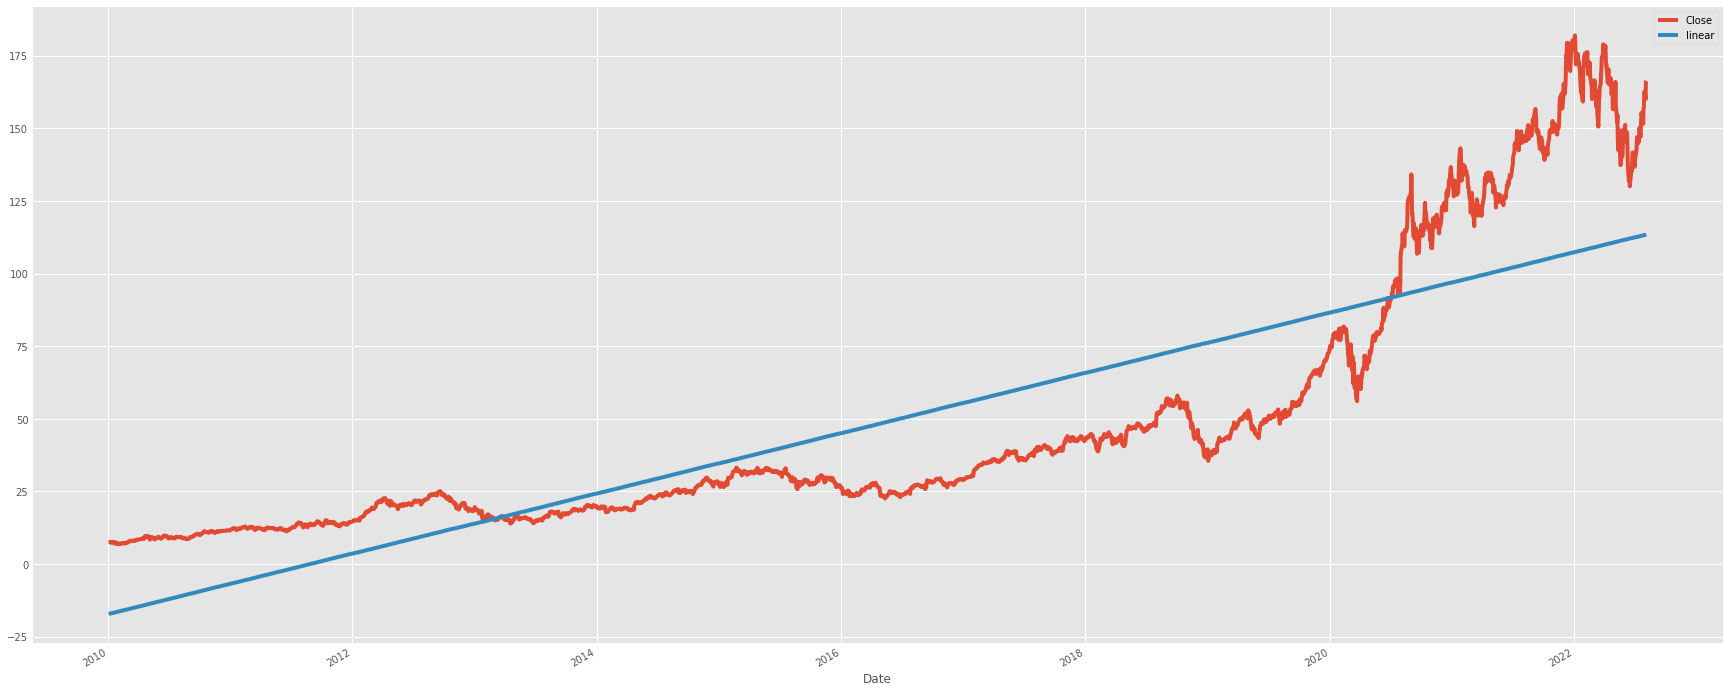

In [15]:
from sklearn import linear_model
x = np.arange(test1.shape[0]).reshape((-1,1))
y = test1.Close.values.reshape((-1,1))
reg = linear_model.LinearRegression()
pred = reg.fit(x, y).predict(x)
test1['linear'] = pred
test1.plot(kind="line", y = ["Close", "linear"],figsize=[27,13])

# Statistical models

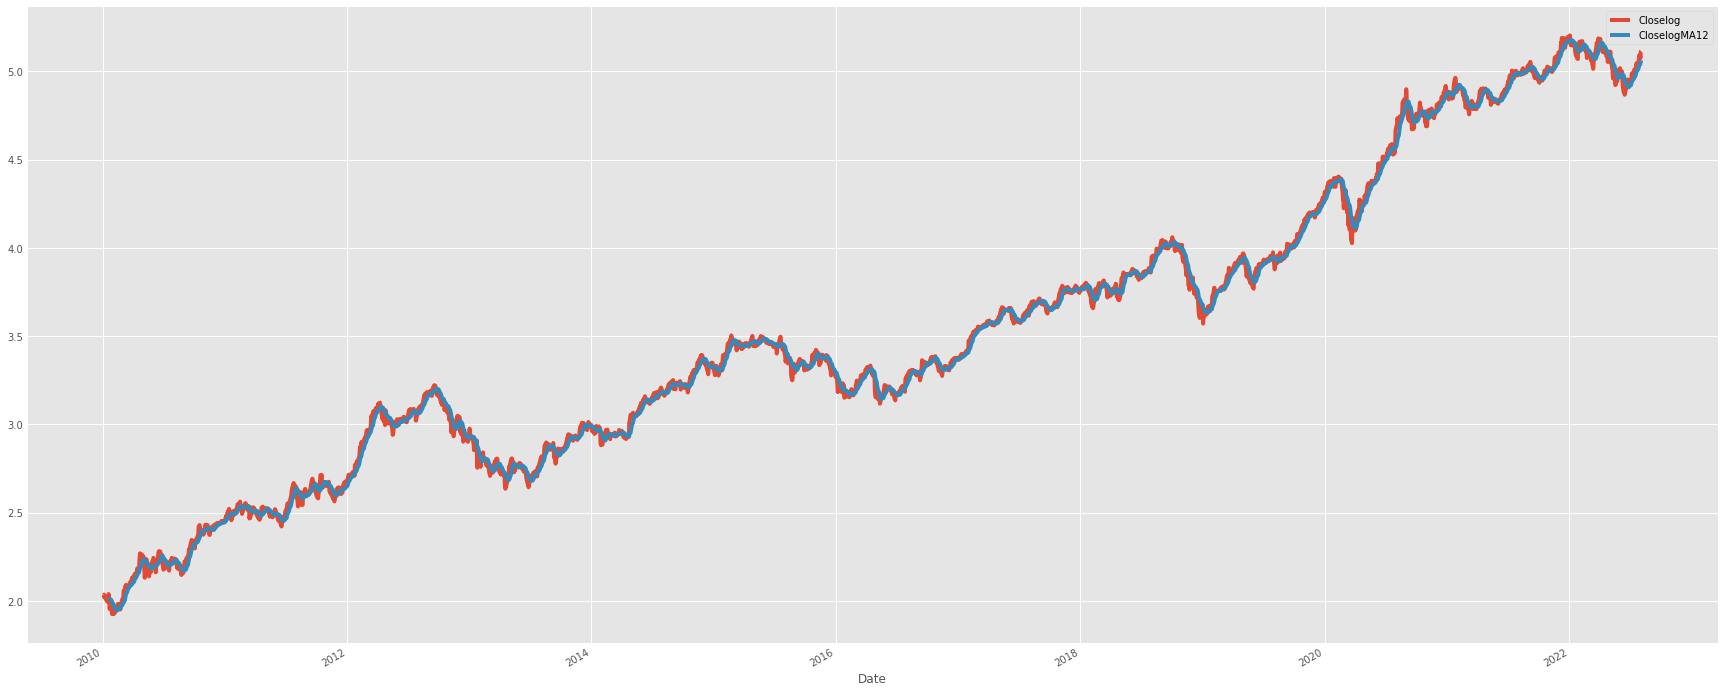

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

test1['Closelog'] = np.log(test1.Close)
test1['CloselogMA12'] =  pd.Series(test1.Closelog).rolling(window=12).mean()
# test1.plot(kind ="line", y=["CloselogMA12", "Closelog"], figsize=(20,10))
test1.plot(kind="line", y = [ "Closelog","CloselogMA12"],figsize=[27,13])

# LSTM

In [17]:
# Configurations for NN
NUM_UNITS = 3
BATCH_SIZE = 64
EPOCHS = 1000
NUM_FEATURES = 1

In [18]:
def rmse(y_preds, y_test):
  mse = mean_squared_error(y_preds, y_test)
  rmse = np.sqrt(mse)
  return rmse

In [19]:
'''
Defining an early stopping callback which will monitor validation loss and check
for improvement for 5 iterations post which it will stop the learning process.
'''
def earlyStopping():
  esCallback = EarlyStopping(monitor='val_loss', 
                             mode='auto',
                             patience=5,
                             verbose=2,
                             restore_best_weights=True
                            )
  return esCallback

In [20]:
# Splitting train data into train and validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
def build_model(lstm_layers):
  model = Sequential()
  if lstm_layers == 1:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  elif lstm_layers == 2:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3))
  elif lstm_layers == 3:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3))
  elif lstm_layers == 4:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3))
  else:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3))
  # model.add(Dense(units=20))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [23]:
model_cnt=1
mean_rmse_score = []
nb_layers = [1]
for layers in nb_layers:
    rmse_scores = []
    for i in range(1): 
        print("Training model : {}/25".format(model_cnt))
        model = build_model(layers)
        model.fit(X_tr, y_tr,
                  epochs=5,
                  batch_size=BATCH_SIZE,
                  validation_data=(X_val, y_val),
                  callbacks=[earlyStopping()],
                  verbose=2
                )
        # Prediction
        y_preds = model.predict(X_test)
        # Compute RMSE and store
        rmse_scores.append(rmse(y_preds, y_test))
        model_cnt+=1
    # Maitaining mean RMSE score for each variation model
    mean_rmse_score.append(np.mean(rmse_scores))

Training model : 1/25
Epoch 1/5
31/31 - 5s - loss: 4238.6343 - val_loss: 4534.6152 - 5s/epoch - 171ms/step
Epoch 2/5
31/31 - 1s - loss: 4213.4365 - val_loss: 4506.2480 - 915ms/epoch - 30ms/step
Epoch 3/5
31/31 - 1s - loss: 4185.0586 - val_loss: 4475.6084 - 889ms/epoch - 29ms/step
Epoch 4/5
31/31 - 1s - loss: 4155.2461 - val_loss: 4444.1553 - 904ms/epoch - 29ms/step
Epoch 5/5
31/31 - 1s - loss: 4125.3394 - val_loss: 4411.4058 - 942ms/epoch - 30ms/step


In [26]:
# Scoring DataFrame:
nblayers_rmse_df = pd.DataFrame({"LSTM layers" : [1],
                                 "RMSE Scores" : mean_rmse_score
                                })
nblayers_rmse_df

,LSTM layers,RMSE Scores
0,1,7.985612


In [27]:
def build_model():
  model = Sequential()
  model.add(LSTM(units=NUM_UNITS, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [29]:
model_cnt = 1
mean_rmse_scores = []
batches = [32]
for batch_size in batches:
    rmse_scores = []
    for i in range(5):
        print("Training model : {}/30".format(model_cnt))
        model = build_model()
        model.fit(X_tr, y_tr,
                  epochs=5,
                  batch_size=batch_size,
                  validation_data=(X_val, y_val),
                  callbacks=[earlyStopping()],
                  verbose=2
                )
        # Prediction
        y_preds = model.predict(X_test)
        # Compute RMSE and store
        rmse_scores.append(rmse(y_preds, y_test))
        model_cnt+=1
    # Maintaining the mean RMSE scores for each batch size
    mean_rmse_scores.append(np.mean(rmse_scores))

Training model : 1/30
Epoch 1/5
62/62 - 6s - loss: 4253.3989 - val_loss: 4538.3608 - 6s/epoch - 90ms/step
Epoch 2/5
62/62 - 2s - loss: 4208.1289 - val_loss: 4490.7339 - 2s/epoch - 30ms/step
Epoch 3/5
62/62 - 2s - loss: 4146.0166 - val_loss: 4406.3096 - 2s/epoch - 29ms/step
Epoch 4/5
62/62 - 2s - loss: 4071.2542 - val_loss: 4339.5845 - 2s/epoch - 30ms/step
Epoch 5/5
62/62 - 2s - loss: 4015.4165 - val_loss: 4286.1572 - 2s/epoch - 30ms/step
Training model : 2/30
Epoch 1/5
62/62 - 4s - loss: 4260.6968 - val_loss: 4559.4219 - 4s/epoch - 70ms/step
Epoch 2/5
62/62 - 2s - loss: 4229.0205 - val_loss: 4506.2969 - 2s/epoch - 30ms/step
Epoch 3/5
62/62 - 2s - loss: 4155.0986 - val_loss: 4408.0664 - 2s/epoch - 30ms/step
Epoch 4/5
62/62 - 2s - loss: 4070.7161 - val_loss: 4341.6553 - 2s/epoch - 29ms/step
Epoch 5/5
62/62 - 2s - loss: 4020.9111 - val_loss: 4296.5732 - 2s/epoch - 30ms/step
Training model : 3/30
Epoch 1/5
62/62 - 4s - loss: 4260.4058 - val_loss: 4560.6143 - 4s/epoch - 71ms/step
Epoch 2/5


In [32]:
# Scoring dataframe
batchsize_rmse_df = pd.DataFrame({"Batch Size" : [str(x) for x in batches],
                                 "RMSE Scores" : mean_rmse_scores
                                })
batchsize_rmse_df = batchsize_rmse_df.sort_values("RMSE Scores").head()
batchsize_rmse_df

,Batch Size,RMSE Scores
0,32,6.292395


In [33]:
def build_model(neurons):
  model = Sequential()
  model.add(LSTM(units=neurons, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [34]:
start = time.time()
cnt=1
mean_rmse = []
neurons_list = [2]
for neurons in neurons_list:
  rmse_scores = []
  for i in range(5):
    print("Training Model " + str(cnt) + "/25")
    model = build_model(neurons)
    model.fit(X_tr, y_tr,
              epochs=2,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[earlyStopping()],
              verbose=2
            )
    # Prediction
    y_preds = model.predict(X_test)
    rmse_scores.append(rmse(y_preds, y_test))
    cnt+=1
  # Compute mean RMSE and store
  mean_rmse.append(np.mean(rmse_scores))
print("Total time taken to train = {:.2f} minutes".format((time.time() - start) / 60))

Training Model 1/25
Epoch 1/2
62/62 - 4s - loss: 4279.1318 - val_loss: 4586.3101 - 4s/epoch - 68ms/step
Epoch 2/2
62/62 - 2s - loss: 4268.3882 - val_loss: 4573.4370 - 2s/epoch - 28ms/step
Training Model 2/25
Epoch 1/2
62/62 - 5s - loss: 4275.4619 - val_loss: 4571.2319 - 5s/epoch - 76ms/step
Epoch 2/2
62/62 - 2s - loss: 4245.7935 - val_loss: 4541.2490 - 2s/epoch - 29ms/step
Training Model 3/25
Epoch 1/2
62/62 - 4s - loss: 4303.8687 - val_loss: 4605.4194 - 4s/epoch - 66ms/step
Epoch 2/2
62/62 - 2s - loss: 4282.7129 - val_loss: 4586.5913 - 2s/epoch - 28ms/step
Training Model 4/25
Epoch 1/2
62/62 - 4s - loss: 4266.5493 - val_loss: 4568.4565 - 4s/epoch - 66ms/step
Epoch 2/2
62/62 - 2s - loss: 4241.7158 - val_loss: 4529.8853 - 2s/epoch - 28ms/step
Training Model 5/25
Epoch 1/2
62/62 - 4s - loss: 4272.7363 - val_loss: 4559.6597 - 4s/epoch - 66ms/step
Epoch 2/2
62/62 - 2s - loss: 4229.8779 - val_loss: 4522.7314 - 2s/epoch - 29ms/step
Total time taken to train = 0.64 minutes


In [37]:
# RMSE Score DataFrame
neurons_rmse_df = pd.DataFrame({"No. of neurons" : [str(x) for x in neurons_list],
                                "RMSE Scores" : mean_rmse})
neurons_rmse_df.sort_values("RMSE Scores").head()

,No. of neurons,RMSE Scores
0,2,7.74397


# Final Model + Training

Here we will combine all the findings from experiment and prepare our final model to train.

In [38]:
def final_model():
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=128))
  model.add(Dense(units=64))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

We will use K-Fold cross validation to validate our model while training.

In [ ]:
NFOLDS=1
kf = KFold(n_splits=NFOLDS, random_state=42,shuffle=True)

In [42]:
models_list = []
history_list = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
    print("\nFOLD : {}\n".format(fold+1))
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]
    
    model = final_model()
    history = model.fit(X_tr, y_tr,
                        epochs=1,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[earlyStopping()],
                        verbose=2
                       )
    # Store model info and model
    history_list.append(history)
    models_list.append(model)


FOLD : 1

62/62 - 4s - loss: 3612.4373 - val_loss: 2349.5461 - 4s/epoch - 68ms/step

FOLD : 2

62/62 - 4s - loss: 3749.2385 - val_loss: 1757.0546 - 4s/epoch - 67ms/step

FOLD : 3

62/62 - 5s - loss: 3833.1965 - val_loss: 2830.0869 - 5s/epoch - 77ms/step

FOLD : 4

62/62 - 5s - loss: 3846.3892 - val_loss: 2628.6545 - 5s/epoch - 78ms/step

FOLD : 5

62/62 - 4s - loss: 3598.3105 - val_loss: 2134.5642 - 4s/epoch - 69ms/step


# Save the Best Model & Scaler


In [31]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [32]:
# Saving model
save_path = '/content/gdrive/My Drive/Stock Price Forecasting/'
modelfilename = save_path + ticker + "_SPF_model"
best_model.save(modelfilename)

# Save Scaler
filename = save_path + ticker + "_spf_scaler.pkl"
with open(filename, 'wb') as f:
    pickle.dump(scaler, f)
    f.close()

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Stock Price Forecasting/AAPL_SPF_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Stock Price Forecasting/AAPL_SPF_model/assets


# Forecasting next day stock prices

In [33]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [34]:
# Making prediction for next day stock price.(t+1) i.e. next day to the current day

# Get the stock price data and store in temp datagframe
temp_df = df.iloc[len(df)-90 : len(df), :]

# get 'Close' price and covert to numpy ndarray
user_data = temp_df['Close'].values

# Load model and scaler
model_path = '/content/gdrive/My Drive/Stock Price Forecasting/AAPL_SPF_model'
scaler_path = '/content/gdrive/My Drive/Stock Price Forecasting/AAPL_spf_scaler.pkl'
model = load_model(model_path)
f = open(scaler_path, 'rb')
scaler = pickle.load(f)

# Scale the data 
user_data = user_data.reshape(1, user_data.shape[0])
user_data = scaler.transform(user_data)

# Convert shape and form of data that is accepted by LSTM RNN
user_data = np.reshape(user_data, (user_data.shape[0], user_data.shape[1], 1))

# Predict next day stock price
prediction = model.predict(user_data)
print(prediction)

[[158.74315]]


# What all is yet to be tried..
- Learning Rate
- Try stateful/ stateless LSTMs
- EDA
- Try predicting for a range of 4 day to 7 days
- Try Qunatile regression outputs
- Why train and val loss have huge difference

# Reference 
1. https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm?newreg=6c00ae0cda854cb29423e93bddaca622

2. https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577 

3. https://colab.research.google.com/notebooks/io.ipynb#scrollTo=D78AM1fFt2ty

# Things I tested
- Vanilla/ Stacked/ Bidirectional
- Batch Size
- Epochs (Early Stopping)
- No. of Neurons and LSTM layers
- No. of dense units and dense layers
- Activation functions
- Cross Validation
- Optimization algos

